# Modeling

General Steps in Modeling

1. Algorithm Selection

2. Fit the models -- turning an algorithm into a model for our specific dataset

    Linear regression is y = mx + b
    
    Our model is final_grade = 1.3 * exam1 + 12

    we "learn" the coefficients

3. Predict + Evaluate

4. Repeat

5. Take the best model and use it on the test set to see if we **overfit**

![](overfit.png)

In [1]:
import numpy as np
import pandas as pd
import wrangle
import matplotlib.pyplot as plt

df = wrangle.wrangle_grades()
df.head()

,exam1,exam2,exam3,final_grade
0,100,90,95,96
1,98,93,96,95
2,85,83,87,87
3,83,80,86,85
4,93,90,96,97


In [2]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(df, train_size=.8, random_state=7)

predictions = pd.DataFrame({
    'actual': train.final_grade
})

In [3]:
predictions.head()

,actual
53,95
2,87
19,93
64,72
5,81


## Simple Model

In [4]:
import sklearn.linear_model

# X must be 2-d
X = train[['exam1']]
# y can be 1-d
y = train.final_grade

# 1. make the thing
lm = sklearn.linear_model.LinearRegression()
# 2. fit the thing
lm.fit(X, y)
# 3. use the thing
predictions['simple_lm'] = lm.predict(X)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_base.py:533: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [5]:
predictions.head()

,actual,simple_lm
53,95,96.237567
2,87,86.495674
19,93,91.741309
64,72,75.255027
5,81,81.999415


In [6]:
lm.coef_, lm.intercept_

(array([0.74937644]), 22.79867647554793)

In [7]:
print('final_grade = {:.3f} * exam1 + {:.3f}'.format(lm.coef_[0], lm.intercept_))

final_grade = 0.749 * exam1 + 22.799


In [8]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

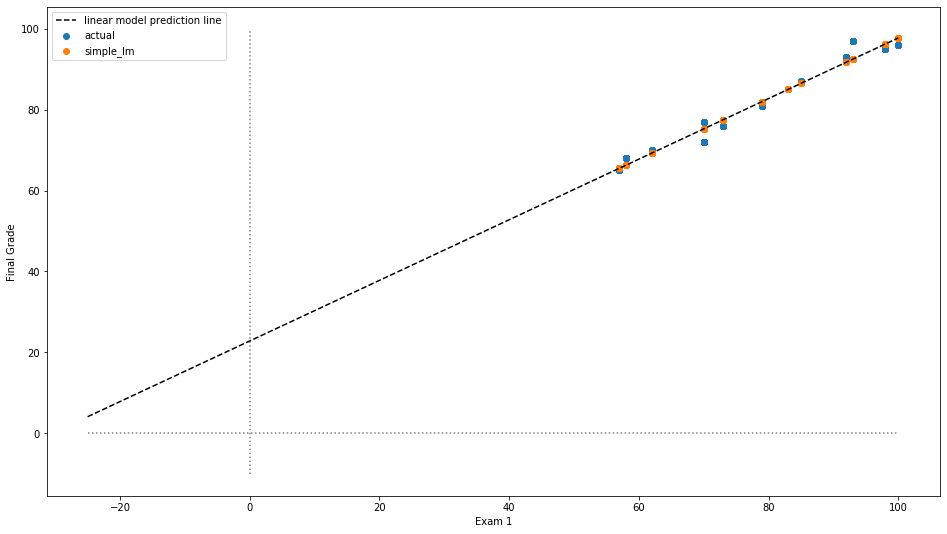

In [9]:
plt.figure(figsize=(16, 9))
plt.scatter(train.exam1, train.final_grade, label='actual')
plt.scatter(train.exam1, predictions.simple_lm, label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Exam 1')
plt.ylabel('Final Grade')
plt.legend()

In [10]:
print(f'For every 1 point increase in Exam 1, we predict a {lm.coef_[0]:.2f} point increase in Final Grade')

For every 1 point increase in Exam 1, we predict a 0.75 point increase in Final Grade


In [11]:
exam1 = np.arange(90, 96)
final_grade = lm.predict(exam1.reshape(-1, 1))
pd.DataFrame(dict(exam1=exam1, predicted_final_grade=final_grade))

,exam1,predicted_final_grade
0,90,90.242556
1,91,90.991932
2,92,91.741309
3,93,92.490685
4,94,93.240061
5,95,93.989438


- **intercept**: Value we predict if x is 0. Depending on our x variables, this may not be valueable
- **coefficients**: define how our prediction changes as x changes. A one-unit increase in x causes our model to predict a `coef` unit change in y, holding all other independent variables constant

## Multiple Regression + RFE

In [16]:
import sklearn.feature_selection

X = train.drop(columns='final_grade')
y = train.final_grade

lm = sklearn.linear_model.LinearRegression()
k = 2

# 1. Transform our X
rfe = sklearn.feature_selection.RFE(lm, 2)
rfe.fit(X, y)
print('selected top 2 features:', X.columns[rfe.support_])
X_rfe = rfe.transform(X)

# 2. Use the transformed x in our model
lm.fit(X_rfe, y)

predictions['multiple_rfe'] = lm.predict(X_rfe)

predictions.head()

selected top 2 features: Index(['exam1', 'exam3'], dtype='object')


,actual,simple_lm,multiple_rfe
53,95,96.237567,96.373858
2,87,86.495674,86.236212
19,93,91.741309,92.331120
64,72,75.255027,74.947898
5,81,81.999415,82.193474


In [17]:
X.columns[rfe.support_]

Index(['exam1', 'exam3'], dtype='object')

In [18]:
lm.coef_, lm.intercept_

(array([0.5753339 , 0.29536726]), 11.635878313748975)

In [19]:
print(f'final_grade = {lm.coef_[0]:.2f} x exam1 + {lm.coef_[1]:.2f} x exam3 + {lm.intercept_:.2f}')

final_grade = 0.58 x exam1 + 0.30 x exam3 + 11.64


In [21]:
X = pd.DataFrame({
    'exam1': [80, 81, 82, 83, 84, 85, 85, 85, 85, 85, 85],
    'exam3': [80, 80, 80, 80, 80, 80, 81, 82, 83, 84, 85]
})

X['predicted_final_grade'] = lm.predict(X)
X

,exam1,exam3,predicted_final_grade
0,80,80,81.291971
1,81,80,81.867305
2,82,80,82.442639
3,83,80,83.017973
4,84,80,83.593307
5,85,80,84.168641
6,85,81,84.464008
7,85,82,84.759375
8,85,83,85.054743
9,85,84,85.350110


## Polynomial Features

Beware the **curse of dimensionality** and **combinatorial explosion**!

|   # Features |   Interaction Terms |   Total Terms (degree=2) |   Total Terms (degree=3) |
|-------------:|--------------------:|-------------------------:|-------------------------:|
|            1 |                   0 |                        2 |                        3 |
|            2 |                   1 |                        5 |                        9 |
|            3 |                   3 |                        9 |                       19 |
|            4 |                   6 |                       14 |                       34 |
|            5 |                  10 |                       20 |                       55 |
|            6 |                  15 |                       27 |                       83 |
|            7 |                  21 |                       35 |                      119 |

- degree = 2, single x -- $y = ax^2 + bx + c$

- degree = 3, single x -- $y = ax^3 + bx^2 + cx + d$

- degree = 2, x0 + x1 -- $y = x_0^2 + x_0x_1 + x_1^2 + x_0 + x_1$

In [38]:
import sklearn.preprocessing

X = train[['exam1', 'exam2', 'exam3']]
y = train.final_grade

# 1. Generate Polynomial Features
poly = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X)
X_poly = pd.DataFrame(poly.transform(X), columns=poly.get_feature_names(X.columns))
X_poly

,exam1,exam2,exam3,exam1 exam2,exam1 exam3,exam2 exam3
0,98.0,93.0,96.0,9114.0,9408.0,8928.0
1,85.0,83.0,87.0,7055.0,7395.0,7221.0
2,92.0,89.0,94.0,8188.0,8648.0,8366.0
3,70.0,75.0,78.0,5250.0,5460.0,5850.0
4,79.0,70.0,85.0,5530.0,6715.0,5950.0
...,...,...,...,...,...,...
76,73.0,70.0,75.0,5110.0,5475.0,5250.0
77,93.0,90.0,96.0,8370.0,8928.0,8640.0
78,98.0,93.0,96.0,9114.0,9408.0,8928.0
79,79.0,70.0,85.0,5530.0,6715.0,5950.0


In [44]:
# 2. Use the features
lm = sklearn.linear_model.LinearRegression()
lm.fit(X_poly, y)

predictions['polynomial'] = lm.predict(X_poly)

In [46]:
for coef, feature in zip(lm.coef_, poly.get_feature_names(X.columns)):
    print(f'{coef:.2f} {feature}')

2.92 exam1
-2.96 exam2
-4.15 exam3
-0.03 exam1 exam2
-0.00 exam1 exam3
0.06 exam2 exam3


Takeaway: interaction terms can be useful if you suspect there's a multiplicative relationship between independent variables. Higher order polynomial features should be used with caution (usually when you have domain knowledge that says this is the right thing to do).

Example: Telco churn, using monthly charges and tenure to predict total charges. monthly charges times tenure will give us a good number for total charges.

## Evaluation

In [51]:
# add a baseline model
predictions['baseline'] = train.final_grade.mean()

In [49]:
import sklearn.metrics

In [52]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial,baseline
53,95,96.237567,96.373858,96.662129,81.296296
2,87,86.495674,86.236212,84.519608,81.296296
19,93,91.741309,92.331120,93.426347,81.296296
64,72,75.255027,74.947898,73.621238,81.296296
5,81,81.999415,82.193474,82.175890,81.296296


In [53]:
sklearn.metrics.mean_squared_error(predictions.actual, predictions.baseline)

120.62825788751715

In [50]:
sklearn.metrics.mean_squared_error(predictions.actual, predictions.simple_lm)

3.887264846655356

In [54]:
sklearn.metrics.mean_squared_error(predictions.actual, predictions.multiple_rfe)

3.2830855240420065

In [55]:
sklearn.metrics.mean_squared_error(predictions.actual, predictions.polynomial)

1.3133167409911504

In [56]:
# calcaulte mean squared error for every column in the df
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual, col))

actual            0.000000
simple_lm         3.887265
multiple_rfe      3.283086
polynomial        1.313317
baseline        120.628258
dtype: float64

## Evaluate on Test

In [57]:
# re-create our polynomial model
X = train[['exam1', 'exam2', 'exam3']]
y = train.final_grade

poly = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X)
X_poly = pd.DataFrame(poly.transform(X), columns=poly.get_feature_names(X.columns))
X_poly

lm = sklearn.linear_model.LinearRegression()
lm.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
# any transformations applied to your training data must be applied to the test as well

X_test = test[['exam1', 'exam2', 'exam3']]
X_test_poly = poly.transform(X_test)

test_predictions = lm.predict(X_test_poly)
test_actual = test.final_grade

In [66]:
mse = sklearn.metrics.mean_squared_error(test_actual, test_predictions)

In [69]:
import math

rmse = math.sqrt(mse)
rmse

1.3953425198907683

Our model is off on it's predictions of final grade by, on average, 1.395 points.

## Further Reading

- [sklearn Linear Models](https://scikit-learn.org/stable/modules/linear_model.html)
- [The Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) and [Combinatorial Explosion](https://en.wikipedia.org/wiki/Combinatorial_explosion)